In [3]:
from pathlib import Path
bad = []
for split, jl in [("train", TRAIN_JL), ("val", VAL_JL)]:
    import json
    with open(jl, "r", encoding="utf-8") as f:
        for i, line in enumerate(f, 1):
            d = json.loads(line)
            p = resolve_img_path(d[IMG_KEY])
            if not Path(p).exists():
                bad.append((split, i, "missing", str(p)))
            elif d[LABEL_KEY] not in CLASS_TO_ID:
                bad.append((split, i, "bad_label", d[LABEL_KEY]))
print("bad rows:", len(bad))
for x in bad[:20]:
    print(x)

bad rows: 0


In [1]:
import os, json, random, time
from pathlib import Path
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image, UnidentifiedImageError
import torchvision
from torchvision import transforms as T
from torch.amp import autocast, GradScaler

# ---------------- CONFIG ----------------
DATA_DIR   = Path("disaster-ai/data/xbd/tier1")   # change if needed
TRAIN_JL   = DATA_DIR / "train.jsonl"
VAL_JL     = DATA_DIR / "val.jsonl"
OUT_DIR    = Path("checkpoints_multiclass")
OUT_DIR.mkdir(parents=True, exist_ok=True)

IMG_KEY    = "image_path"     # matches your JSONL
LABEL_KEY  = "damage"         # matches your JSONL

CLASSES    = ['no-damage','minor-damage','major-damage','destroyed']
N_CLASSES  = 4
CLASS_TO_ID = {c:i for i,c in enumerate(CLASSES)}  # string -> int

IMG_SIZE   = 224
BATCH_SIZE = 32
EPOCHS     = 20
LR         = 3e-4
WEIGHT_DECAY = 1e-4

# Notebook-safe dataloaders
NUM_WORKERS = 0          # critical for Jupyter/macOS to avoid spawn/pickle issues
PIN_MEMORY  = False      # keep False on CPU/MPS
SEED       = 42
BACKBONE   = "resnet18"   # 'resnet18', 'resnet50', 'vit_b_16', 'efficientnet_b0'
# ----------------------------------------

def set_seed(seed=42):
    random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

def read_jsonl(path: Path) -> List[Dict]:
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line: continue
            rows.append(json.loads(line))
    return rows

def resolve_img_path(p: str | Path) -> Path:
    p = Path(p)
    return p if p.is_absolute() else (DATA_DIR / p)

class ImgJsonlDS(Dataset):
    def __init__(self, rows: List[Dict], transform=None):
        self.rows = rows
        self.t = transform or (lambda x: x)

    def __len__(self): return len(self.rows)

    def __getitem__(self, i):
        r = self.rows[i]
        img_path = resolve_img_path(r[IMG_KEY])
        # label → id
        try:
            y_id = CLASS_TO_ID[r[LABEL_KEY]]
        except KeyError:
            raise KeyError(f"Row {i}: unknown label '{r.get(LABEL_KEY)}'. "
                           f"Expected one of {list(CLASS_TO_ID.keys())}")
        # load image
        try:
            img = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            raise FileNotFoundError(f"Row {i}: image not found -> {img_path}")
        except UnidentifiedImageError:
            raise UnidentifiedImageError(f"Row {i}: unreadable/corrupt image -> {img_path}")

        return self.t(img), torch.tensor(y_id, dtype=torch.long)

def get_transforms(train: bool):
    if train:
        return T.Compose([
            T.Resize(int(IMG_SIZE*1.15)),
            T.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0), ratio=(0.75, 1.33)),
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(p=0.1),
            T.ColorJitter(0.2,0.2,0.2,0.05),
            T.ToTensor(),
            T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
        ])
    else:
        return T.Compose([
            T.Resize(int(IMG_SIZE*1.15)),
            T.CenterCrop(IMG_SIZE),
            T.ToTensor(),
            T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
        ])

def build_model(backbone=BACKBONE):
    if backbone == "resnet18":
        m = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
        m.fc = nn.Linear(m.fc.in_features, N_CLASSES)
    elif backbone == "resnet50":
        m = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)
        m.fc = nn.Linear(m.fc.in_features, N_CLASSES)
    elif backbone == "efficientnet_b0":
        m = torchvision.models.efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        m.classifier[1] = nn.Linear(m.classifier[1].in_features, N_CLASSES)
    elif backbone == "vit_b_16":
        m = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1)
        m.heads.head = nn.Linear(m.heads.head.in_features, N_CLASSES)
    else:
        raise ValueError("Unknown BACKBONE")
    return m

def class_counts(rows: List[Dict]):
    counts = [0]*N_CLASSES
    for r in rows:
        counts[CLASS_TO_ID[r[LABEL_KEY]]] += 1
    return counts

def confusion_matrix(preds, targets, n_classes=N_CLASSES):
    cm = torch.zeros(n_classes, n_classes, dtype=torch.long)
    for p,t in zip(preds, targets):
        cm[t, p] += 1
    return cm

def main():
    set_seed(SEED)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    use_amp = (device.type == "cuda")
    print("Device:", device)

    train_rows = read_jsonl(TRAIN_JL)
    val_rows   = read_jsonl(VAL_JL)
    print(f"Train samples: {len(train_rows)} | Val samples: {len(val_rows)}")

    ds_tr = ImgJsonlDS(train_rows, get_transforms(train=True))
    ds_va = ImgJsonlDS(val_rows, get_transforms(train=False))

    # Handle class imbalance
    counts = class_counts(train_rows)
    print("Class counts (train):", dict(zip(CLASSES, counts)))
    total = sum(counts)
    # inverse frequency weights
    class_weights = torch.tensor([(total/c) if c > 0 else 0.0 for c in counts], dtype=torch.float)
    sample_weights = [class_weights[CLASS_TO_ID[r[LABEL_KEY]]].item() for r in train_rows]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    loader_tr = DataLoader(
        ds_tr, batch_size=BATCH_SIZE, sampler=sampler,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=False
    )
    loader_va = DataLoader(
        ds_va, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=False
    )

    model = build_model(BACKBONE).to(device)
    loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device) if class_weights.sum() > 0 else None)
    opt = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
    scaler = GradScaler("cuda") if use_amp else None

    best_acc = -1.0  # ensures we save best.pt at epoch 1

    for epoch in range(1, EPOCHS+1):
        model.train()
        t0 = time.time()
        run_loss, seen = 0.0, 0

        for xb, yb in loader_tr:
            xb, yb = xb.to(device, non_blocking=False), yb.to(device, non_blocking=False)
            opt.zero_grad(set_to_none=True)
            if use_amp:
                with autocast(device_type="cuda"):
                    logits = model(xb)
                    loss = loss_fn(logits, yb)
                scaler.scale(loss).backward()
                scaler.step(opt)
                scaler.update()
            else:
                logits = model(xb)
                loss = loss_fn(logits, yb)
                loss.backward()
                opt.step()
            run_loss += float(loss.item()) * xb.size(0)
            seen += xb.size(0)

        scheduler.step()
        train_loss = run_loss / max(1, seen)

        # --------- validation ----------
        model.eval()
        all_preds, all_tgts = [], []
        with torch.no_grad():
            for xb, yb in loader_va:
                xb, yb = xb.to(device, non_blocking=False), yb.to(device, non_blocking=False)
                logits = model(xb)
                pred = logits.argmax(1)
                all_preds.append(pred.cpu()); all_tgts.append(yb.cpu())

        preds = torch.cat(all_preds); tgts = torch.cat(all_tgts)
        acc = (preds == tgts).float().mean().item()

        cm = confusion_matrix(preds, tgts, N_CLASSES)
        per_class_acc = cm.diag() / cm.sum(dim=1).clamp(min=1)
        msg_accs = ", ".join(f"{CLASSES[i]}={per_class_acc[i]:.3f}" for i in range(N_CLASSES))
        print(f"[{epoch:02d}/{EPOCHS}] train_loss={train_loss:.4f}  val_acc={acc:.4f}  "
              f"per_class: {msg_accs}  (took {time.time()-t0:.1f}s)")

        if acc > best_acc:
            best_acc = acc
            torch.save({
                "model_state": model.state_dict(),
                "backbone": BACKBONE,
                "classes": CLASSES,
                "img_size": IMG_SIZE,
                "acc": best_acc,
            }, OUT_DIR / "best.pt")
            print(f"  ✅ Saved best checkpoint (val_acc={best_acc:.4f}) -> {OUT_DIR/'best.pt'}")

    # also save final
    torch.save(model.state_dict(), OUT_DIR / "last_weights_only.pt")
    print("Training complete. Best val_acc:", best_acc)

# Notebook: just run main()
main()

Device: cpu
Train samples: 1792 | Val samples: 448
Class counts (train): {'no-damage': 1042, 'minor-damage': 166, 'major-damage': 247, 'destroyed': 337}
[01/20] train_loss=0.9047  val_acc=0.4821  per_class: no-damage=0.425, minor-damage=0.500, major-damage=0.557, destroyed=0.595  (took 156.7s)
  ✅ Saved best checkpoint (val_acc=0.4821) -> checkpoints_multiclass/best.pt
[02/20] train_loss=0.6980  val_acc=0.2946  per_class: no-damage=0.142, minor-damage=0.714, major-damage=0.262, destroyed=0.583  (took 156.7s)
[03/20] train_loss=0.6042  val_acc=0.3058  per_class: no-damage=0.088, minor-damage=0.595, major-damage=0.639, destroyed=0.595  (took 167.7s)
[04/20] train_loss=0.5164  val_acc=0.3951  per_class: no-damage=0.268, minor-damage=0.357, major-damage=0.738, destroyed=0.560  (took 159.9s)
[05/20] train_loss=0.4366  val_acc=0.4174  per_class: no-damage=0.264, minor-damage=0.405, major-damage=0.689, destroyed=0.702  (took 156.7s)
[06/20] train_loss=0.3811  val_acc=0.4911  per_class: no-dam

In [5]:
from pathlib import Path
import torch, torchvision
from PIL import Image
from torchvision import transforms as T

# 1) Point to your project root explicitly (edit if needed)
PROJECT_ROOT = Path.cwd()   # or Path("/absolute/path/to/your/project")
CKPT_DIR = PROJECT_ROOT / "checkpoints_multiclass"

print("Notebook CWD:", Path.cwd())
print("Checkpoint dir:", CKPT_DIR.resolve())

# 2) Pick a checkpoint robustly: prefer best.pt, else newest .pt file
candidates = [CKPT_DIR / "best.pt", CKPT_DIR / "last_weights_only.pt"]
if CKPT_DIR.exists():
    others = sorted(CKPT_DIR.glob("*.pt"), key=lambda p: p.stat().st_mtime, reverse=True)
    for p in others:
        if p not in candidates:
            candidates.append(p)

ckpt_path = next((p for p in candidates if p.exists()), None)
assert ckpt_path is not None, f"No checkpoints found in {CKPT_DIR}. Run training first or fix the path."

print("Loading checkpoint:", ckpt_path.name)
ckpt = torch.load(ckpt_path, map_location="cpu")

classes  = ckpt.get("classes", ['no-damage','minor-damage','major-damage','destroyed'])
img_size = ckpt.get("img_size", 224)
backbone = ckpt.get("backbone", "resnet18")

# ---- rebuild model to match checkpoint ----
def build_model(backbone, n_classes):
    if backbone == "resnet18":
        m = torchvision.models.resnet18(weights=None); m.fc = torch.nn.Linear(m.fc.in_features, n_classes)
    elif backbone == "resnet50":
        m = torchvision.models.resnet50(weights=None); m.fc = torch.nn.Linear(m.fc.in_features, n_classes)
    elif backbone == "efficientnet_b0":
        m = torchvision.models.efficientnet_b0(weights=None); m.classifier[1] = torch.nn.Linear(m.classifier[1].in_features, n_classes)
    elif backbone == "vit_b_16":
        m = torchvision.models.vit_b_16(weights=None); m.heads.head = torch.nn.Linear(m.heads.head.in_features, n_classes)
    else:
        raise ValueError(f"Unknown backbone in checkpoint: {backbone}")
    return m

model = build_model(backbone, len(classes))
state = ckpt.get("model_state", ckpt)  # handle both full dict and weights-only
model.load_state_dict(state)
model.eval()

tform = T.Compose([
    T.Resize(int(img_size*1.15)),
    T.CenterCrop(img_size),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

def predict_one(img_path: str):
    img = Image.open(img_path).convert("RGB")
    x = tform(img).unsqueeze(0)
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).squeeze(0)
        top = probs.argmax().item()
    return classes[top], float(probs[top])

# Example:
# label, p = predict_one("disaster-ai/data/xbd/tier1/images/your_post_disaster.png")
# print(label, p)

Notebook CWD: /Users/rudrabrahmbhatt/Documents/AI_Powered_Disaster_Response_&_Resource_Allocation
Checkpoint dir: /Users/rudrabrahmbhatt/Documents/AI_Powered_Disaster_Response_&_Resource_Allocation/checkpoints_multiclass
Loading checkpoint: best.pt


In [7]:
label, prob = predict_one("disaster-ai/data/xbd/tier1/images/socal-fire_00001323_post_disaster.png")
print("Predicted:", label, "| Confidence:", f"{prob:.2f}")

Predicted: destroyed | Confidence: 0.98


In [9]:
import json

# load first 5 validation rows
with open("disaster-ai/data/xbd/tier1/val.jsonl", "r") as f:
    rows = [json.loads(next(f)) for _ in range(5)]

for r in rows:
    img_path = r["image_path"]
    true_lbl = r["damage"]
    pred_lbl, prob = predict_one(DATA_DIR / img_path)
    print(f"GT: {true_lbl:12s} | Pred: {pred_lbl:12s} | Conf: {prob:.2f} | File: {img_path}")

GT: no-damage    | Pred: no-damage    | Conf: 0.68 | File: images/palu-tsunami_00000125_post_disaster.png
GT: destroyed    | Pred: minor-damage | Conf: 0.87 | File: images/hurricane-matthew_00000120_post_disaster.png
GT: no-damage    | Pred: minor-damage | Conf: 0.63 | File: images/midwest-flooding_00000410_post_disaster.png
GT: no-damage    | Pred: no-damage    | Conf: 0.83 | File: images/hurricane-harvey_00000084_post_disaster.png
GT: no-damage    | Pred: no-damage    | Conf: 0.85 | File: images/hurricane-florence_00000062_post_disaster.png


In [11]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



Overall Validation Accuracy: 63.39%

Classification Report:

              precision    recall  f1-score   support

   no-damage      0.856     0.663     0.747       261
minor-damage      0.232     0.310     0.265        42
major-damage      0.524     0.721     0.607        61
   destroyed      0.509     0.643     0.568        84

    accuracy                          0.634       448
   macro avg      0.530     0.584     0.547       448
weighted avg      0.688     0.634     0.649       448



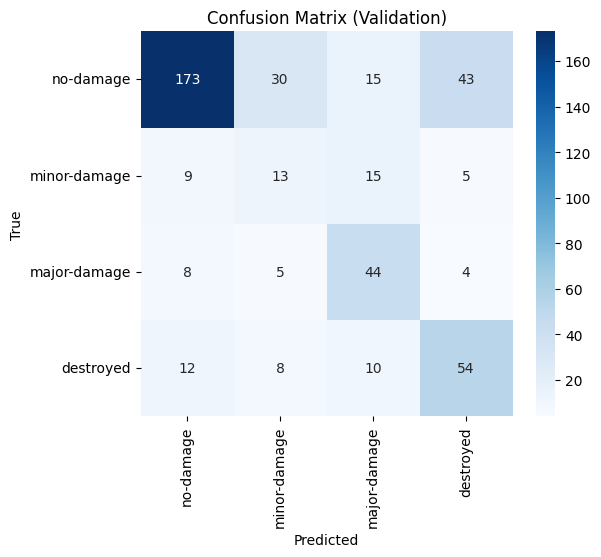

In [11]:
import json
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from pathlib import Path

# Paths & constants (must match training)
DATA_DIR = Path("disaster-ai/data/xbd/tier1")
VAL_JL   = DATA_DIR / "val.jsonl"
CLASSES  = ['no-damage','minor-damage','major-damage','destroyed']

# Load all validation rows
with open(VAL_JL, "r") as f:
    val_rows = [json.loads(line) for line in f]

y_true, y_pred = [], []

for r in val_rows:
    img_path = DATA_DIR / r["image_path"]
    true_lbl = r["damage"]
    pred_lbl, _ = predict_one(img_path)   # <-- uses your trained model
    y_true.append(true_lbl)
    y_pred.append(pred_lbl)

# ---- Overall accuracy ----
acc = accuracy_score(y_true, y_pred)
print(f"\nOverall Validation Accuracy: {acc*100:.2f}%\n")

# ---- Report ----
print("Classification Report:\n")
print(classification_report(y_true, y_pred, labels=CLASSES, digits=3))

# ---- Confusion matrix ----
cm = confusion_matrix(y_true, y_pred, labels=CLASSES)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Validation)")
plt.show()